# Introduction
## 6.1  Define the Task

#### Dataset Information
Dataset will be the cifar100 dataset from tensorflow. This is a multi-class classification problem with 100 different classes of images to be classified. There are 500 training images and 100 testing images for each of the 100 classes so this is a balanced dataset.

#### Accuracy Metric
Balanced classification problems such as this a good measure of success will be accuracy and area under the reciever operating characteristic curve. Guessing all one type of class would lead to an accuracy of 1% since there are 100 different classes. 

#### Evaluation
The model will be evaluated using a holdout test set of 10,000 images consisting of 100 of each class. The training set will consist of 500 images of each class for a total of 50,000 images.




In [4]:
### Show data class information metrics
## show that the counts of the labels are balanced

In [5]:
from tensorflow.keras.datasets import cifar100

This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

## 6.2 Develop a Model
### Data Preparation

The data consists of images that are 32x32.  There are 50,000 training images and 10,000 test images. 

## Examine the data

In [6]:
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

In [7]:
print('tensor shape')
print('\ttraining images:', train_images.shape)
print('\ttraining labels:', train_labels.shape)
print('\ttraining images:', train_images.dtype)
print('\ttraining labels:', train_labels.dtype)
print('\ttest images:', test_images.shape)
print('\ttest labels:', test_labels.shape)

tensor shape
	training images: (50000, 32, 32, 3)
	training labels: (50000, 1)
	training images: uint8
	training labels: int32
	test images: (10000, 32, 32, 3)
	test labels: (10000, 1)


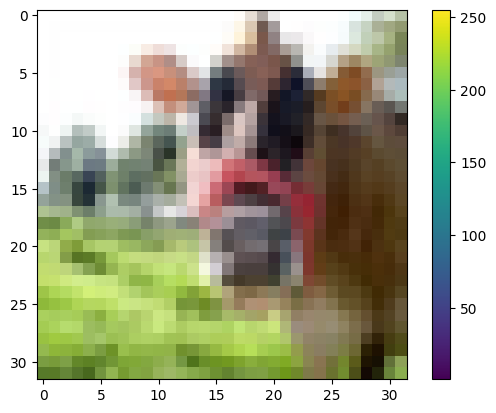

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

## Preprocess
1. Reshape to flatten 32x32x3 to vector
2. Cast vector as floats
3. Rescale from [0,1]

In [8]:
train_images_flat = train_images.reshape((50000, 32*32*3)).astype('float32') / 255.
test_images_flat = test_images.reshape((10000, 32*32*3)).astype('float32') / 255.


In [10]:
train_labels

array([[19],
       [29],
       [ 0],
       ...,
       [ 3],
       [ 7],
       [73]])

In [11]:
from tensorflow.keras.utils import to_categorical

orig_label = train_labels[0]
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


In [12]:

print('\'', orig_label, '\'', 'as one-hot vector:\n', train_labels[0], sep='')

'[19]'as one-hot vector:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


### Baseline Model
Start smal, smallest amout of layers can do and small # of units then increase size

Only a baseline model if it has "statistical power" meaning ??

**Selecting loss function**
Chose categorical crossentropy but why?
General loss function for classification tasks where the evaluation metric is RCO AUC - need to figure out why that is. Used as a proxy, hope is that the lower the crossentropy the higher the ROC AUC will be 

**Final Layer**  
Multi-class single label classification => 
* last layer activation: **softmax**  
* Loss function: **categorical_crossentropy**


In [39]:
# build
from tensorflow.keras import models, layers

# create empty network
network = models.Sequential()

# add 2 layers
network.add(layers.Dense(64, activation='relu', input_shape=(32 * 32 * 3, )))
network.add(layers.Dense(100, activation='softmax'))

network.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

network.fit(train_images_flat, train_labels, epochs=5, batch_size=128)

Epoch 1/5
391/391 [==============================] - 3s 6ms/step - loss: 4.5079 - accuracy: 0.0234
Epoch 2/5
391/391 [==============================] - 3s 7ms/step - loss: 4.1959 - accuracy: 0.0551
Epoch 3/5
391/391 [==============================] - 2s 6ms/step - loss: 4.0096 - accuracy: 0.0830
Epoch 4/5
391/391 [==============================] - 2s 6ms/step - loss: 3.9147 - accuracy: 0.1020
Epoch 5/5
391/391 [==============================] - 2s 6ms/step - loss: 3.8459 - accuracy: 0.1156


Base model has achieved an 11.5% accuracy which is higher than 10% if we were to randomly guess so this is a suitable base model on which to improve upon.

### 6.2.4 Develop a model that overfits
Once have model with statistical power => question is now is model sufficiently powerful?  
Enough layers? Enough Parameters? to properly model problem at hand  
Universal tension in ML is optimization vs generalization  

To figure out how big a model must develop model that overfits  
1. Add layers
2. make layers bigger
3. train for more epochs

Monitor the training loss and validation loss as well as training and validation values for any metrics that you care about  

**Overfitting:** Once see that model's performance on validation data begins to degrade




In [66]:
def build_network(units_list, learning_rate=0.01, epochs=5):
    network = models.Sequential()
    
    #first layer - needs input_shape
    network.add(layers.Dense(units_list[0], activation='relu', input_shape=(32 * 32 * 3, )))
    
    #middle layers
    for units in units_list[1:]:
        network.add(layers.Dense(units))
    
    #last layer
    network.add(layers.Dense(100, activation='softmax'))
    
    
    network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    history = network.fit(
        train_images_flat, train_labels, 
        epochs=epochs, 
    )
    
    return history

## Hyperparameter search space
**Layers**
1,2,3 layers
**Units**
[64, 128, 256, 512, 1024]
**Learning Rate**
[0.01, 0.05, 0.1, 0.2, 0.5]

In [55]:
unit_space = [64, 128, 256, 512, 1024]
learning_rate_space = [0.01, 0.1, 0.3]
layer_space = [1,2,3]


In [58]:
def get_search_grid(unit_space, learning_rate_space, layer_space):
    search_space = []
    # layer1space.append(2)
    for units in unit_space:
        for lr in learning_rate_space:
            search_space.append([[units], lr])
    layer2space = []
    for units1 in unit_space:
        for units2 in unit_space:
            for lr in learning_rate_space:
                search_space.append([[units1, units2],lr])
    layer3space = []
    for u1 in unit_space:
        for u2 in unit_space:
            for u3 in unit_space:
                for lr in learning_rate_space:
                    search_space.append([[u1, u2, u3], lr])
    return search_space

search_space = get_search_grid(unit_space, learning_rate_space, layer_space)

In [60]:
print('Length of search space: ', len(search_space))
search_space[50:55]      

Length of search space:  465


[[[256, 128], 0.3],
 [[256, 256], 0.01],
 [[256, 256], 0.1],
 [[256, 256], 0.3],
 [[256, 512], 0.01]]

In [68]:
def run_grid_search(search_space):
    accuracy_history = []
    loss_history = []
    for params in search_space:
        history = build_network(params[0], params[1], epochs=5)
        accuracy_history.append(history.history['accuracy'])
        loss_history.append(history.history['loss'])
    return accuracy_history,loss_history

In [ ]:
acc_hist, loss_hist = run_grid_search(search_space[10:14])

In [62]:
history_2_layer_128_512 = build_network([128,512])


Epoch 1/5
1563/1563 [==============================] - 16s 9ms/step - loss: 4.2205 - accuracy: 0.0481
Epoch 2/5
1563/1563 [==============================] - 13s 9ms/step - loss: 4.0111 - accuracy: 0.0782
Epoch 3/5
1563/1563 [==============================] - 14s 9ms/step - loss: 3.9132 - accuracy: 0.0940
Epoch 4/5
1563/1563 [==============================] - 14s 9ms/step - loss: 3.8444 - accuracy: 0.1073
Epoch 5/5
1563/1563 [==============================] - 15s 9ms/step - loss: 3.7992 - accuracy: 0.1162


In [65]:
print(history_2_layer_128_512.params)

# check the keys of history object
print(history_2_layer_128_512.history.keys())

print(history_2_layer_128_512.history['accuracy'])


{'verbose': 1, 'epochs': 5, 'steps': 1563}
dict_keys(['loss', 'accuracy'])
[0.04808000102639198, 0.07818000018596649, 0.09397999942302704, 0.10726000368595123, 0.11618000268936157]


In [45]:
history_3_layer_128_128_512 = build_network([128,128,512])

Epoch 1/5
391/391 [==============================] - 6s 12ms/step - loss: 4.2047 - accuracy: 0.0584
Epoch 2/5
391/391 [==============================] - 5s 12ms/step - loss: 3.9009 - accuracy: 0.0992
Epoch 3/5
391/391 [==============================] - 5s 12ms/step - loss: 3.8024 - accuracy: 0.1156
Epoch 4/5
391/391 [==============================] - 5s 14ms/step - loss: 3.7392 - accuracy: 0.1276
Epoch 5/5
391/391 [==============================] - 5s 12ms/step - loss: 3.6859 - accuracy: 0.1351


In [46]:
history_3_layer_512_128_128 = build_network([512,128,128])

Epoch 1/5
391/391 [==============================] - 13s 31ms/step - loss: 4.3248 - accuracy: 0.0620
Epoch 2/5
391/391 [==============================] - 12s 30ms/step - loss: 3.8175 - accuracy: 0.1162
Epoch 3/5
391/391 [==============================] - 12s 30ms/step - loss: 3.6722 - accuracy: 0.1422
Epoch 4/5
391/391 [==============================] - 12s 30ms/step - loss: 3.5761 - accuracy: 0.1577
Epoch 5/5
391/391 [==============================] - 12s 30ms/step - loss: 3.5096 - accuracy: 0.1724


In [47]:
history_2_layer_512_128 = build_network([512, 128])

Epoch 1/5
391/391 [==============================] - 13s 31ms/step - loss: 4.2092 - accuracy: 0.0697
Epoch 2/5
391/391 [==============================] - 12s 30ms/step - loss: 3.8116 - accuracy: 0.1196
Epoch 3/5
391/391 [==============================] - 12s 31ms/step - loss: 3.6724 - accuracy: 0.1446
Epoch 4/5
391/391 [==============================] - 12s 32ms/step - loss: 3.5815 - accuracy: 0.1598
Epoch 5/5
391/391 [==============================] - 12s 31ms/step - loss: 3.5112 - accuracy: 0.1691


In [40]:
# create empty network
network = models.Sequential()

# add 2 layers
network.add(layers.Dense(128, activation='relu', input_shape=(32 * 32 * 3, )))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(100, activation='softmax'))

network.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

history1 = network.fit(
    train_images_flat, train_labels, 
    epochs=5, 
    batch_size=128
)

Epoch 1/5
391/391 [==============================] - 4s 9ms/step - loss: 4.2244 - accuracy: 0.0598
Epoch 2/5
391/391 [==============================] - 3s 9ms/step - loss: 3.8759 - accuracy: 0.1079
Epoch 3/5
391/391 [==============================] - 3s 8ms/step - loss: 3.7416 - accuracy: 0.1279
Epoch 4/5
391/391 [==============================] - 4s 9ms/step - loss: 3.6581 - accuracy: 0.1409
Epoch 5/5
391/391 [==============================] - 4s 10ms/step - loss: 3.5847 - accuracy: 0.1541


In [34]:
val_loss = history1.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
 label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

KeyError: 'val_loss'

### 6.2.5 Hyperparamater tuning

goal now is to maximize generalization performance  
repeatedly modify model and train it and evaluate it (**on evaluation data NOT test data**)  



**Search Space**
1. learning rate
2. units
3. layers
    ii. add or remove layers
4. add dropout